In [192]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFCamembertModel, CamembertTokenizer, CamembertConfig,TFBertModel,CamembertTokenizer, TFCamembertForSequenceClassification
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [193]:
df = pd.read_excel(io="./data/historique_interventions_IA.xlsx", sheet_name="liste inter CATEGORISEES LIGHT")
df.columns = [title.lower().replace(" ", "_") for title in df.columns]
df.columns

Index(['description', 'activity_text', 's-ens', 'cat'], dtype='object')

In [194]:
df['s-ens_cleaned'] = df['s-ens'].str.lower()
df = df[['description','s-ens_cleaned']]
df.dropna(inplace=True)
df.columns = ['description', "labels"]

In [195]:
count = df.groupby('labels').count().reset_index()

nb_min_to_keep = 10 

result = count[count['description'] > nb_min_to_keep]
result['labels']
nb_targets = result['labels'].nunique()
display(count)

,labels,description
0,autom,13
1,barre ionisante,3
2,bi,5
3,bol bouchon,25
4,cellules,61
5,climet,6
6,communication,18
7,convoyeur entrée,9
8,convoyeur principal,30
9,courroie,1


In [196]:
list_label_to_keep = result['labels'].unique()

In [197]:
df = df[df['labels'].isin(list_label_to_keep)]

In [198]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pickle
# Création de l'encodeur
le = LabelEncoder()
nb_targets = df['labels'].nunique()
# Entraînement de l'encodeur et transformation des labels
df['labels_encoded'] = le.fit_transform(df['labels'])

y = df['labels_encoded']


filename = './save_model/labelencoder.pkl'
pickle.dump(le, open(filename, 'wb'))


X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(np.array(df['description']), y,
                                                   test_size=0.2,
                                                   random_state = 0,
                                                   stratify=y,
                                                   shuffle=True)
X_train_nlp, X_val_nlp, y_train_nlp, y_val_nlp = train_test_split(np.array(X_train_nlp), np.array(y_train_nlp),
                                                   test_size=0.1,
                                                   random_state = 0,
                                                   stratify=y_train_nlp,
                                                   shuffle=True)

In [199]:
tokenizer = CamembertTokenizer("./save_model/tokenizer_model.model")

model = TFCamembertModel.from_pretrained("jplu/tf-camembert-base",num_labels=nb_targets)
LONGUEUR_MAX_COMMENTAIRE = df.description.str.len().max()
output_tokenizer_entrainement = tokenizer(list(X_train_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
output_tokenizer_tests = tokenizer(list(X_test_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
output_tokenizer_val = tokenizer(list(X_val_nlp),max_length=LONGUEUR_MAX_COMMENTAIRE, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)

Some layers from the model checkpoint at jplu/tf-camembert-base were not used when initializing TFCamembertModel: ['lm_head']
- This IS expected if you are initializing TFCamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFCamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFCamembertModel were initialized from the model checkpoint at jplu/tf-camembert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFCamembertModel for predictions without further training.


In [200]:
entrees_ids = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='input_token', dtype='int32')
entrees_masks = tf.keras.layers.Input(shape=(LONGUEUR_MAX_COMMENTAIRE,), name='masked_token', dtype='int32')
sortie_camemBERT = model([entrees_ids,entrees_masks])

# Instanciation du modèle avec Keras
model_camemBERT = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs = sortie_camemBERT,trainable=False)
model_camemBERT.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                              

In [201]:
output = Dense(nb_targets, activation='softmax')(sortie_camemBERT[1])  # Use pooled representation
model = tf.keras.Model(inputs=[entrees_ids, entrees_masks], outputs=output)
model.layers[2].trainable = False  # Disable training of CamemBERT

model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-2), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  


 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                                  
                              pooler_output=(None, 768)                                           
                             , past_key_values=None, hi                                           
                             dden_states=None, attentio                                           
                             ns=None, cross_attentions=                                           
                             None)                                                                
                                                                                                  
 dense (De

In [202]:
early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

callbacks=[early]
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=10, verbose=1, batch_size = 2,callbacks=callbacks, workers=-1, 
                    validation_data=([output_tokenizer_val['input_ids'],output_tokenizer_val['attention_mask']],y_val_nlp))

Epoch 1/10
187/187 [==============================] - 33s 139ms/step - loss: 2.5582 - accuracy: 0.2193 - val_loss: 2.2965 - val_accuracy: 0.3095
Epoch 2/10
187/187 [==============================] - 24s 127ms/step - loss: 2.2506 - accuracy: 0.3075 - val_loss: 2.0765 - val_accuracy: 0.3810
Epoch 3/10
187/187 [==============================] - 23s 125ms/step - loss: 2.0433 - accuracy: 0.3904 - val_loss: 1.9651 - val_accuracy: 0.3333
Epoch 4/10
187/187 [==============================] - 23s 124ms/step - loss: 1.8415 - accuracy: 0.4439 - val_loss: 1.9292 - val_accuracy: 0.3810
Epoch 5/10
187/187 [==============================] - 23s 125ms/step - loss: 1.8130 - accuracy: 0.4305 - val_loss: 1.8146 - val_accuracy: 0.4048
Epoch 6/10
187/187 [==============================] - 23s 125ms/step - loss: 1.6309 - accuracy: 0.5241 - val_loss: 1.7963 - val_accuracy: 0.5000
Epoch 7/10
187/187 [==============================] - 23s 125ms/step - loss: 1.6216 - accuracy: 0.4599 - val_loss: 1.7204 - val_ac

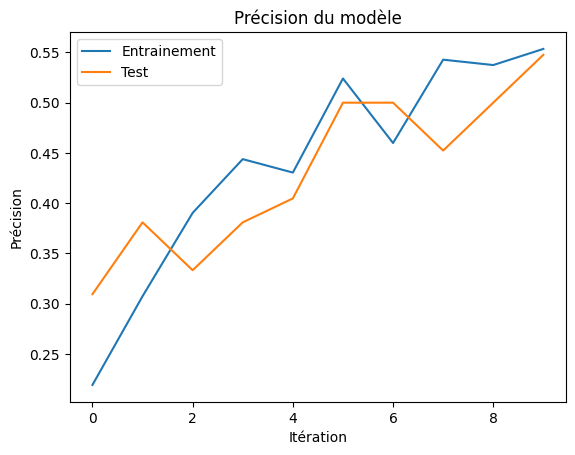

In [203]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()


In [204]:
model.layers[2].trainable = True
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(1e-7), metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model (TFCame  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 mbertModel)                 ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [205]:
history = model.fit([output_tokenizer_entrainement['input_ids'],output_tokenizer_entrainement['attention_mask']],y_train_nlp,
                    epochs=20, verbose=1, batch_size = 8,callbacks=callbacks, workers=-1, use_multiprocessing=False,
                    validation_data=([output_tokenizer_val['input_ids'],output_tokenizer_val['attention_mask']],y_val_nlp))

Epoch 1/20
47/47 [==============================] - 108s 2s/step - loss: 1.2684 - accuracy: 0.6203 - val_loss: 1.4771 - val_accuracy: 0.5952
Epoch 2/20
47/47 [==============================] - 80s 2s/step - loss: 1.2555 - accuracy: 0.6203 - val_loss: 1.4554 - val_accuracy: 0.5714
Epoch 3/20
47/47 [==============================] - 79s 2s/step - loss: 1.1754 - accuracy: 0.6604 - val_loss: 1.4379 - val_accuracy: 0.5714
Epoch 4/20
47/47 [==============================] - 80s 2s/step - loss: 1.2009 - accuracy: 0.6444 - val_loss: 1.4248 - val_accuracy: 0.5714
Epoch 5/20
47/47 [==============================] - 79s 2s/step - loss: 1.1462 - accuracy: 0.6524 - val_loss: 1.4124 - val_accuracy: 0.5952
Epoch 6/20
47/47 [==============================] - 79s 2s/step - loss: 1.1443 - accuracy: 0.6738 - val_loss: 1.4010 - val_accuracy: 0.5952
Epoch 7/20
47/47 [==============================] - 79s 2s/step - loss: 1.1348 - accuracy: 0.6524 - val_loss: 1.3912 - val_accuracy: 0.5952
Epoch 8/20
47/47 [=

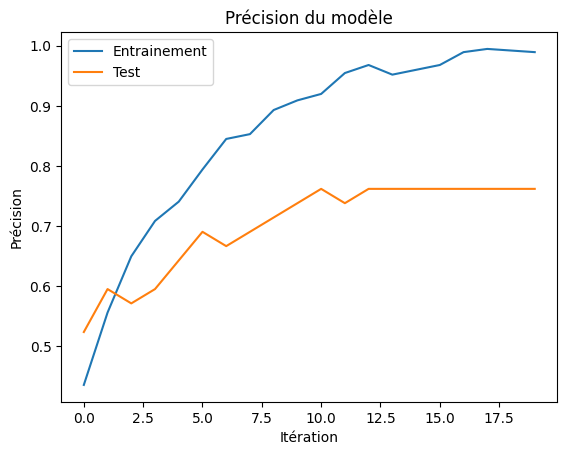

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Précision du modèle')
plt.ylabel('Précision')
plt.xlabel('Itération')
plt.legend(['Entrainement', 'Test'], loc='upper left')
plt.show()


In [ ]:
def encode_texts(texts, tokenizer, max_seq_length):
    input_ids = []

    encoded = tokenizer(texts,max_length=max_seq_length, padding='max_length', truncation=False, return_tensors='tf',add_special_tokens=True)
    input_ids.append([encoded["input_ids"],encoded["attention_mask"]])
    return input_ids

def prediction(model, max_seq_length, *args) :
    texts = list(*args)
    to_test = encode_texts(texts=texts, tokenizer=tokenizer, max_seq_length=max_seq_length)
    proba = model.predict(*to_test)
    indexes = np.argmax(proba, axis=1)
    return le.inverse_transform(indexes)

In [ ]:
text_test = 'Défaut de com HMI IPC.'
test1 = 'Ecran IPC'
test2 = 'defaut communication sur hmi ipc'
prediction(model, LONGUEUR_MAX_COMMENTAIRE,[text_test,test1,test2])

1/1 [==============================] - 4s 4s/step


array(['hmi', 'ipc', 'communication'], dtype=object)

In [ ]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

# Assuming you have trained your model and obtained predictions
# Replace this with your actual test/validation data and predictions
y_true = y_test_nlp.to_numpy().reshape(1,-1)
y_pred = le.transform(prediction(model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp)).reshape(1,-1)


# Flatten the multi-label data for f1_score calculation
f1 = f1_score(y_true.ravel(), y_pred.ravel(), average='macro')

print("Macro F1 Score (Multi-label):", f1)

4/4 [==============================] - 4s 855ms/step
Macro F1 Score (Multi-label): 0.5643769385148697


In [ ]:
from sklearn.metrics import classification_report

y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# Use classification_report
report = classification_report(y_true_flat, y_pred_flat)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.60      0.60      0.60         5
           2       0.41      0.58      0.48        12
           3       0.67      0.50      0.57         4
           4       0.56      0.83      0.67         6
           5       0.78      0.78      0.78        18
           6       0.76      0.76      0.76        21
           7       0.77      0.71      0.74        14
           8       0.50      0.33      0.40         6
           9       1.00      0.25      0.40         4
          10       1.00      0.50      0.67         2
          11       0.67      0.67      0.67         3
          12       0.00      0.00      0.00         2
          13       0.57      0.80      0.67         5

    accuracy                           0.65       105
   macro avg       0.66      0.55      0.56       105
weighted avg       0.68      0.65      0.64       105



In [ ]:
model_path = "./save_model/"
date = datetime.now()
model.save(model_path+f"nlp_{nb_targets}_nb_class_{date}.h5")

/home/apprenant/miniconda3/envs/nlp_fail/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
custom_objects = {'TFCamembertModel': TFCamembertModel}
model_path =  "save_model/nlp_14_nb_class_2023-11-21 21:05:49.799700.h5"
loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)

loaded_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_token (InputLayer)    [(None, 40)]                 0         []                            
                                                                                                  
 masked_token (InputLayer)   [(None, 40)]                 0         []                            
                                                                                                  
 tf_camembert_model_3 (TFCa  TFBaseModelOutputWithPooli   1106219   ['input_token[0][0]',         
 membertModel)               ngAndCrossAttentions(last_   52         'masked_token[0][0]']        
                             hidden_state=(None, 40, 76                                           
                             8),                                                            

In [ ]:
test1 = 'Remplacemetn ecran IPC'
test2 = 'Ecran IPC figé'
test3 = "Perte de COM"
prediction(loaded_model, LONGUEUR_MAX_COMMENTAIRE,[test1,test2,test3])

1/1 [==============================] - 3s 3s/step


array(['ipc', 'hmi', 'communication'], dtype=object)

In [ ]:

y_true = y_test_nlp.to_numpy().reshape(1,-1)
y_pred = le.transform(prediction(loaded_model, LONGUEUR_MAX_COMMENTAIRE,X_test_nlp)).reshape(1,-1)


# Flatten the multi-label data for f1_score calculation
f1 = f1_score(y_true.ravel(), y_pred.ravel(), average='macro')

print("Macro F1 Score (Multi-label):", f1)

4/4 [==============================] - 4s 831ms/step
Macro F1 Score (Multi-label): 0.6785303010092925


In [ ]:

y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

# Use classification_report
report = classification_report(y_true_flat, y_pred_flat)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.67      0.80      0.73         5
           2       0.58      0.58      0.58        12
           3       1.00      0.50      0.67         4
           4       0.45      0.83      0.59         6
           5       0.94      0.83      0.88        18
           6       0.75      0.86      0.80        21
           7       0.77      0.71      0.74        14
           8       0.60      0.50      0.55         6
           9       0.67      0.50      0.57         4
          10       1.00      0.50      0.67         2
          11       1.00      1.00      1.00         3
          12       0.50      0.50      0.50         2
          13       0.67      0.80      0.73         5

    accuracy                           0.72       105
   macro avg       0.76      0.66      0.68       105
weighted avg       0.75      0.72      0.72       105

